Finally we come to a classic application of Gibbs sampling.  The [Ising Model](https://en.wikipedia.org/wiki/Ising_model) is a simple model in statistical mechanics.

   - Consider a graph with nodes indexed by $n$.
   - Each node can in state $x_n = \pm 1$.
   - Let $J_{n,m}$ be the "interaction" between nodes $n$ and $m$.  Typically we fix $J>0$ and set $J_{n,m} = J$ is $n,m$ are neighbours, and $J_{n,m}=0$ otherwise.
   - Let $H>=0$ be the "external field".
   - Then the energy of the system is
   
$$ E(x) = E(x;J,H) = -\Big( \frac12 \sum_{n,m} J_{n,m} x_m x_n + \sum_n Hx_n \Big). $$

   - The factor of $1/2$ occurs as we'll consider $J_{n,m}$ and also $J_{m,n}$.
   - Let $\beta = 1/T$ the "inverse temperature" and then the probability we'll be in state $x$ is
   
$$ \mathbb P(x) = \mathbb P(x|J,H,\beta) \propto e^{-\beta E(x)}. $$

   - The normalising factor is usually denoted by $Z = \sum_x e^{-\beta E(x)}$.
   - Finally note that we have parameters $J, H$ and $\beta$, and the relative probability (i.e. once we have normalised by $Z$) is invariant under scaling all these parameters.  So we may fix e.g. $J=1$.

## Gibbs sampling

Select $n$ and consider $\mathbb P(x_n = 1 | \text{all other } x_m )$.  This is equal to

$$ \frac{\mathbb P(x_n=1 , (x_m))}{\mathbb P(x_n=1 , (x_m)) + \mathbb P(x_n=-1 , (x_m))}. $$

Now, we find that

$$ \mathbb P(x_n | (x_m) ) = \exp\Big( \beta x_n \sum_m J_{n,m} x_m + \beta H x_n \Big)
\exp\Big( \text{Other terms not involving } x_n \Big). $$
The $1/2$ factor has disappeared as we have now fixed an ordering.  Thus

$$ \mathbb P(x_n=1 | (x_m)) = \frac{e^{\beta \sum_m J_{n,m} x_m + H} }{e^{\beta \sum_m J_{n,m} x_m + H} + e^{-\beta \sum_m J_{n,m} x_m - H}}
= \frac{ 1 }{1 + e^{-2\beta \sum_m J_{n,m} x_m - 2H}} = \frac{1}{1+e^{-2\beta b_n}}, $$
say, where $b_n = \sum_m J_{n,m} x_m + H$.


So the Gibbs model is to loop over each $n$, and with this probability set $x_n=1$, otherwise setting it to $-1$.  Actually, as in general there will be spacial correlations, it makes more sense to randomly select the $n$ each time.

An alternative to direct sampling is to perform a Metropolis--Hastings step: considering changing $x_n$ from it's current state.  If this decreases the energy then we accept the flip; otherwise accept with probability $e^{-\beta \Delta E}$.

It seems that in practise there is not much difference in algorithm.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

We'll work with a 2D rectangular grid with periodic boundary conditions.

In [2]:
class IsingGrid:
    def __init__(self, height, width, extfield, invtemp):
        self.width, self.height, self.extfield, self.invtemp = height, width, extfield, invtemp
        self.grid = np.zeros([self.width, self.height], dtype=np.int8) + 1
        
    def plot(self):
        plt.imshow(self.grid, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
    
    def make_random(self):
        self.grid = (np.random.randint(0, 2, size = self.width * self.height).reshape(self.width, self.height) * 2) - 1
    
    def neighbours(self, x, y):
        n = []
        if x == 0:
            n.append( (self.width-1, y) )
        else:
            n.append( (x-1, y) )
        if x == self.width-1:
            n.append( (0, y) )
        else:
            n.append( (x+1, y) )
        if y == 0:
            n.append( (x, self.height-1) )
        else:
            n.append( (x, y-1) )
        if y == self.height-1:
            n.append( (x, 0) )
        else:
            n.append( (x, y+1) )
        return n
    
    def local_energy(self, x, y):
        return self.extfield + sum( self.grid[xx,yy] for (xx, yy) in self.neighbours(x, y) )
    
    def total_energy(self):
        # Could maybe do some numpy games here, but periodic boundary conditions make this tricky.
        # This function is only ever useful for very small grids anyway.
        energy = - self.extfield * np.sum(self.grid)
        energy += - sum( self.grid[x, y] * sum( self.grid[xx, yy] for (xx, yy) in self.neighbours(x, y) )
                        for x in range(self.width) for y in range(self.height) ) / 2
        return energy
    
    def probability(self):
        return np.exp( - self.invtemp * self.total_energy() )
    
    def gibbs_move(self):
        n = np.random.randint(0, self.width * self.height)
        y = n // self.width
        x = n % self.width
        p = 1 / (1 + np.exp(-2 * self.invtemp * self.local_energy(x,y)))
        if np.random.random() <= p:
            self.grid[x,y] = 1
        else:
            self.grid[x,y] = -1
            
    def from_number(self, n):
        """Convert an integer 0 <= n < 2**(width*height) into a grid."""
        binstring = bin(n)[2:]
        binstring = "0" * (N - len(binstring)) + binstring
        self.grid = np.array([int(x)*2-1 for x in binstring], dtype=np.int8).reshape(self.width, self.height)
    
    def to_number(self):
        """Convert grid into an integer."""
        flat = [self.grid[x, y] for x in range(self.width) for y in range(self.height)]
        return sum(2**n * (int(x)+1)//2 for n, x in enumerate(reversed(flat)))

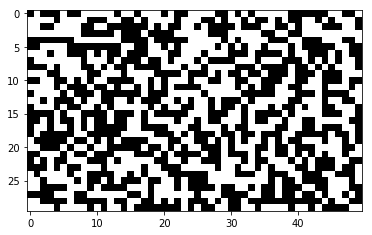

In [3]:
gg = IsingGrid(30, 50, 0, .3)
gg.make_random()
gg.plot()

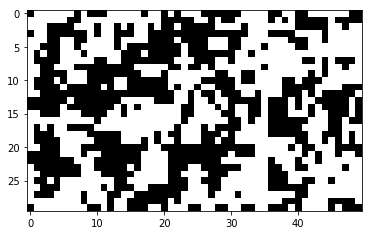

In [4]:
for _ in range(100000):
    gg.gibbs_move()
gg.plot()

# Check this is correct

For a grid with $N$ points, we have $2^N$ states, and so for very small $N$, we can directly sample.

In [5]:
def make_comparison_plot(W, H, field, invtemp, samples=1000000):
    # Generate all possible combinations and compute probability.
    gg = IsingGrid(W, H, field, invtemp)
    N = gg.width * gg.height
    prob = []
    for n in range(2**N):
        gg.from_number(n)
        prob.append( gg.probability() )
    total = sum(prob)
    prob = [ (n, x/total) for n, x in enumerate(prob) ]
    prob.sort(key = lambda pair: pair[1])
    
    # Randomly sample a large number of states
    for _ in range(10000):
        gg.gibbs_move()

    count = [0]*(2**N)
    for _ in range(samples):
        gg.gibbs_move()
        count[ gg.to_number() ] += 1

    total = sum(count)
    count = [ x/total for x in count ]
    
    # Plot
    fig, axes = plt.subplots(figsize=(12,6))
    axes.set_xlim([0,2**N])
    _ = axes.plot( range(2**N), [x for _, x in prob], lw=2 )
    _ = axes.scatter( range(2**N), [count[n] for n, _ in prob] )

In [7]:
make_comparison_plot(3, 3, 0, .1)

NameError: name 'N' is not defined

In [8]:
make_comparison_plot(3, 3, 1, .1)

NameError: name 'N' is not defined

# Application: Image denoising

Sources:

   - [Lecture](http://statweb.stanford.edu/~jtaylo/courses/stats352/notes/ising.pdf)
   
   
Suppose we have a binary image $Z = Z_{x,y}$ (where for convenience, "binary" will mean $\pm 1$ valued) and that the image has had some "noise" added.  We'll assume a "bit-flip" model, so the image we see if $Y = Y_{x,y}$ with

\begin{align*} \mathbb P(Y=y | Z=z) &= \prod_{x,y} \begin{cases} q &: y_{x,y} = z_{x,y}, \\ 1-q &: y_{x,y} \not= z_{x,y}, \end{cases}
\\&= \prod_{x,y} \begin{cases} q &: y_{x,y}z_{x,y} = 1, \\ 1-q &: y_{x,y}z_{x,y} = -1, \end{cases}.
\end{align*}

thanks to my meaning of "binary".

Here presumably $q$ is close to $1$.  This seems like a hopeless problem unless we make some assumptions on the structure of $Z$.  Let's assume that $Z$ is "clumpy", so there is high correlation between each value $Z_{x,y}$ and it's neighbours.  This allows us to apply the Ising model, as we'll see.

Indeed, with $i=(x,y)$ and again setting $J_{i,j} = 1$ only when $i,j$ are neighbours in a 2D grid, then let us assume that

$$ \mathbb P(Z=z) \propto \exp\Big( \sum_{i,j} J_{i,j} z_i z_j \Big). $$

That is, an Ising model with zero external field.  We can now apply Bayes rule,

$$ \mathbb P(Z=z|Y=y) \propto \mathbb P(Y=y | Z=z) \mathbb P(Z=z). $$

Now, for $a,b\in\{\pm1\}$ we have that

$$ \begin{cases} q &: ab = 1 \\ 1-q &: ab=-1 \end{cases} = q^{(ab+1)/2} (1-q)^{(1-ab)/2}
= \Big( \frac{q}{1-q} \Big)^{ab} q^{1/2} (1-q)^{1/2}. $$

Thus, with $h = \log(q/(1-q)) = \operatorname{logit}(q)$,

$$ \log P(Z=z|Y=y) \propto \exp\Big( \sum_{i,j} J_{i,j} z_i z_j + \sum_i h z_i y_i \Big). $$

This is exactly an Ising model with a _varying_ external field $(hy_i)$.  To get the conventions correct, we set $\beta=2$ and halve $h$.

Finding the [MAP](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) means checking all possible values for $z=(z_i)$, which is an exponentially sized search space.  Instead, we could consider using the mean of the posterior, which we can estimate by MCMC methods: if $(x_i)$ are iid samples of $X$ then $\mathbb E(X) \approx \frac1n \sum_{i=1}^n x_i$.

So our plan of attack is to re-write our Ising model to allow a varying external field...  The following is a slightly quick'n'dirty subclass.

In [9]:
class IsingGridVaryingField(IsingGrid):
    def __init__(self, height, width, extfield, invtemp):
        super().__init__(height, width, 0, invtemp)
        self.vextfield = extfield
        
    def local_energy(self, x, y):
        return self.vextfield[x,y] + sum( self.grid[xx,yy] for (xx, yy) in self.neighbours(x, y) )

I'll use `skimage` to load our PNG file, but I guess you could use `pillow` etc.

In [13]:
import skimage.io
import scipy.io

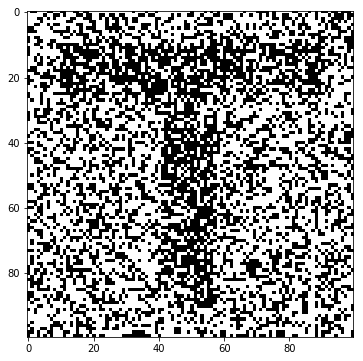

In [14]:

noisy = scipy.io.loadmat("data4")['imgMat']
fig, axes = plt.subplots(figsize=(10,6))
axes.imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)

In [32]:
def IsingDeNoise(noisy, q, burnin = 10000, loops = 500000):
    h = 0.5 * np.log(q / (1-q))
    gg = IsingGridVaryingField(noisy.shape[0], noisy.shape[1], h*noisy, 2)
    gg.grid = np.array(noisy)
    
    # Burn-in
    for _ in range(burnin):
        gg.gibbs_move()
    
    # Sample
    avg = np.zeros_like(noisy).astype(np.float64)
    for _ in range(loops):
        gg.gibbs_move()
        avg += gg.grid
    return avg / loops

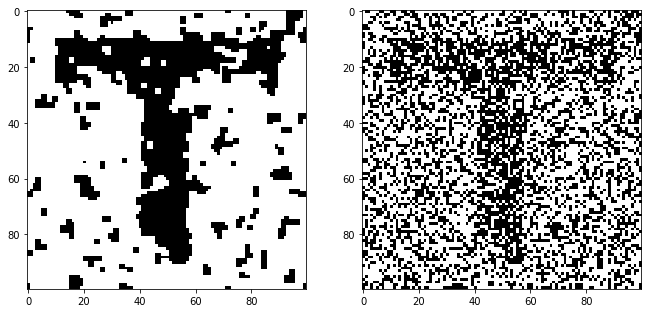

In [27]:
avg = IsingDeNoise(noisy, 0.9)
avg[avg >= 0] = 1
avg[avg < 0] = -1
avg = avg.astype(np.int)

fig, axes = plt.subplots(ncols=2, figsize=(11,6))
axes[0].imshow(avg, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)

Notice that this is dependent on a "guessed" value for $q$ (though for the sort of images this will work on, we can probably estimate $q$).  Here's what happens for other values...

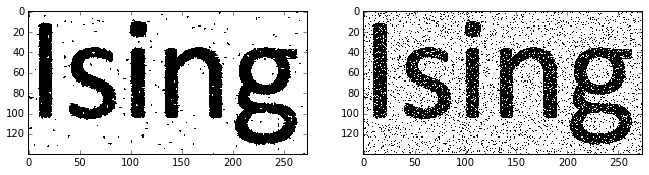

In [139]:
avg = IsingDeNoise(noisy, 0.99)
avg[avg >= 0] = 1
avg[avg < 0] = -1
avg = avg.astype(np.int)

fig, axes = plt.subplots(ncols=2, figsize=(11,6))
axes[0].imshow(avg, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)

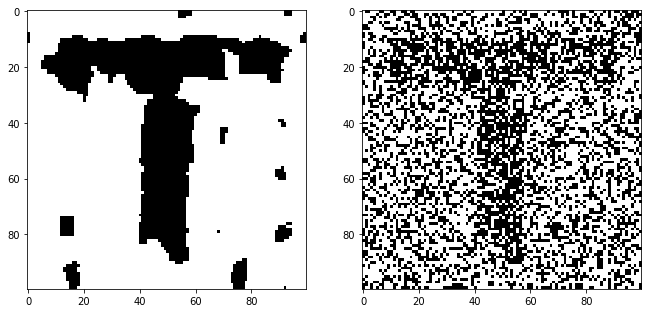

In [36]:
avg = IsingDeNoise(noisy, 0.6)
avg[avg >= 0] = 1
avg[avg < 0] = -1
avg1 = avg.astype(np.int)

fig, axes = plt.subplots(ncols=2, figsize=(11,6))
axes[0].imshow(avg1, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)

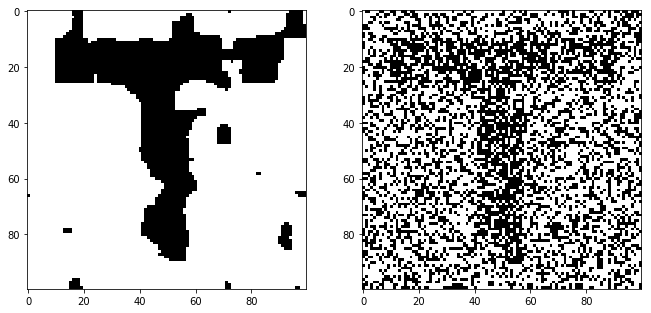

In [37]:
avg = IsingDeNoise(noisy, 0.6)
avg[avg >= 0] = 1
avg[avg < 0] = -1
avg2 = avg.astype(np.int)

fig, axes = plt.subplots(ncols=2, figsize=(11,6))
axes[0].imshow(avg2, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)

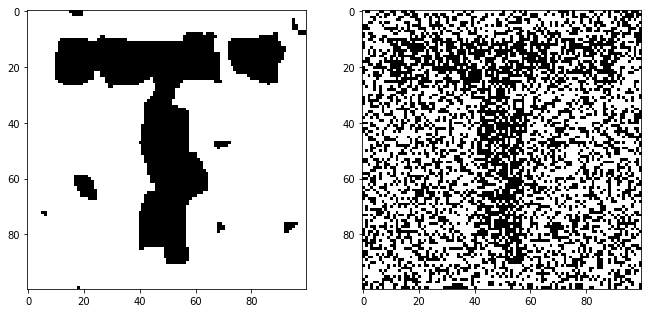

In [38]:
avg = IsingDeNoise(noisy, 0.6)
avg[avg >= 0] = 1
avg[avg < 0] = -1
avg3 = avg.astype(np.int)

fig, axes = plt.subplots(ncols=2, figsize=(11,6))
axes[0].imshow(avg3, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)

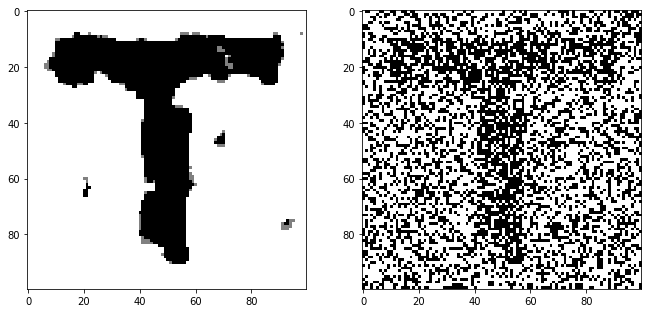

In [42]:
avgs = []
for i in range(10):
    avg = IsingDeNoise(noisy, 0.6)
    avg[avg >= 0] = 1
    avg[avg < 0] = -1
    avgs.append(avg.astype(np.int))


fig, axes = plt.subplots(ncols=2, figsize=(11,6))
axes[0].imshow(sum(avgs), cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)